# Градиентный бустинг с CATBOOST (публикация на Хабр NewTechAudit)

Цитата из Википедии "CatBoost — открытая программная библиотека, разработанная компанией Яндекс и реализующая уникальный патентованный алгоритм построения моделей машинного обучения, использующий одну из оригинальных схем градиентного бустинга. Основное API для работы с библиотекой реализовано для языка Python, также существует реализация для языка программирования R."

In [1]:
%%bash
pip install catboost

In [2]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import * 
from catboost import datasets

In [3]:
# Получаем тестовый датасет
(train_df, test_df) = catboost.datasets.amazon()

In [4]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [5]:
X = train_df.drop("ACTION", axis=1)
y = train_df["ACTION"]

In [6]:
# Catboost необходимо сказать, какие признаки категориальные, для этого необходимо передать массив с индексами категориальных фичей
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


In [7]:
# Посчитаем соотношение 0 и 1 в метках. Есть дисбаланс классов
y.value_counts()

1    30872
0     1897
Name: ACTION, dtype: int64

In [8]:
# Формирование csv файлов с датасетами 
dataset_dir = "./amazon"

if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
    
    
train_df.to_csv(os.path.join(dataset_dir, 'train.tsv'), 
                index=False, sep='\t', header=False)


test_df.to_csv(os.path.join(dataset_dir, 'test.tsv'), 
              index=False, sep='\t', header=False)


train_df.to_csv(os.path.join(dataset_dir, 'train.csv'),
                index=False, sep=',', header=True)


test_df.to_csv(os.path.join(dataset_dir, 'test.csv'),
              index=False, sep=',', header=True)

In [9]:
!head amazon/train.csv

ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
1,36724,14457,118219,118220,117884,117879,267952,19721,117880
1,36135,5396,117961,118343,119993,118321,240983,290919,118322
1,42680,5905,117929,117930,119569,119323,123932,19793,119325
0,45333,14561,117951,117952,118008,118568,118568,19721,118570
1,25993,17227,117961,118343,123476,118980,301534,118295,118982
1,19666,4209,117961,117969,118910,126820,269034,118638,126822
1,31246,783,117961,118413,120584,128230,302830,4673,128231


In [10]:
# Формирование файла с описанием типа данных
from catboost.utils import create_cd

In [11]:
feature_names = dict()

for column, name in enumerate(train_df):
    if column == 0:
        continue
    feature_names[column-1] = name
    

create_cd(
    label=0,
    cat_features=list(range(1, train_df.columns.shape[0])),
    feature_names=feature_names,
    output_path=os.path.join(dataset_dir, 'train.cd')
)

In [12]:
!cat amazon/train.cd

0	Label	
1	Categ	RESOURCE
2	Categ	MGR_ID
3	Categ	ROLE_ROLLUP_1
4	Categ	ROLE_ROLLUP_2
5	Categ	ROLE_DEPTNAME
6	Categ	ROLE_TITLE
7	Categ	ROLE_FAMILY_DESC
8	Categ	ROLE_FAMILY
9	Categ	ROLE_CODE


In [13]:
# Формирование Pool
pool1 = Pool(data=X, label=y, cat_features=cat_features)

pool2 = Pool(
    data=os.path.join(dataset_dir, 'train.csv'),
    delimiter=',',
    column_description=os.path.join(dataset_dir, 'train.cd'),
    has_header=True
)

pool3 = Pool(data=X, cat_features=cat_features)

X_prepared = X.values.astype(str).astype(object)

pool4 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

In [14]:
print("Dataset shape")
print(f"Dataset 1: {str(pool1.shape)}")
print(f"Dataset 2: {str(pool2.shape)}")
print(f"Dataset 3: {str(pool3.shape)}")
print(f"Dataset 4: {str(pool4.shape)}")
print()
print("Column names")
print(f"Dataset 1: {pool1.get_feature_names()}")
print(f"Dataset 2: {pool2.get_feature_names()}")
print(f"Dataset 3: {pool3.get_feature_names()}")
print(f"Dataset 4: {pool4.get_feature_names()}")

Dataset shape
Dataset 1: (32769, 9)
Dataset 2: (32769, 9)
Dataset 3: (32769, 9)
Dataset 4: (32769, 9)

Column names
Dataset 1: ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']
Dataset 2: ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']
Dataset 3: ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']
Dataset 4: ['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


In [15]:
# Разбивка данных на тестовый и тренировочный датасет
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.45, random_state=42)

In [17]:
# Описание модели
from catboost import CatBoostClassifier

In [18]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.15
)

In [19]:
# Обучение модели
model.fit(X_train, y_train,
         cat_features=cat_features,
         eval_set=(X_test, y_test),
          verbose=35
)
print(f"Model is fitted: {str(model.is_fitted())}")
print(f"Model params: {model.get_params()}")

0:	learn: 0.5308996	test: 0.5289152	best: 0.5289152 (0)	total: 79.7ms	remaining: 15.9s
35:	learn: 0.1685548	test: 0.1553164	best: 0.1553164 (35)	total: 1.84s	remaining: 8.4s
70:	learn: 0.1593061	test: 0.1527978	best: 0.1527978 (70)	total: 5.45s	remaining: 9.91s
105:	learn: 0.1512245	test: 0.1519111	best: 0.1518266 (103)	total: 9.33s	remaining: 8.28s
140:	learn: 0.1442951	test: 0.1518200	best: 0.1514874 (124)	total: 13.2s	remaining: 5.53s
175:	learn: 0.1381953	test: 0.1520130	best: 0.1514874 (124)	total: 17s	remaining: 2.32s
199:	learn: 0.1342670	test: 0.1519438	best: 0.1514874 (124)	total: 19.4s	remaining: 0us

bestTest = 0.1514873617
bestIteration = 124

Shrink model to first 125 iterations.
Model is fitted: True
Model params: {'iterations': 200, 'learning_rate': 0.15}


In [20]:
model = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.15,
    custom_loss = ['AUC', 'Accuracy']
)

model.fit(X_train, y_train,
         cat_features=cat_features,
         eval_set=(X_test, y_test),
          verbose=35,
          # plot=True
)

0:	learn: 0.5336131	test: 0.5326369	best: 0.5326369 (0)	total: 25.5ms	remaining: 5.07s
35:	learn: 0.1674512	test: 0.1560540	best: 0.1560540 (35)	total: 2.02s	remaining: 9.2s
70:	learn: 0.1589373	test: 0.1538040	best: 0.1536771 (68)	total: 3.67s	remaining: 6.67s
105:	learn: 0.1514922	test: 0.1528275	best: 0.1527260 (101)	total: 5.46s	remaining: 4.84s
140:	learn: 0.1447493	test: 0.1523771	best: 0.1523510 (138)	total: 7.27s	remaining: 3.04s
175:	learn: 0.1380789	test: 0.1522657	best: 0.1522170 (145)	total: 9.16s	remaining: 1.25s
199:	learn: 0.1334049	test: 0.1520542	best: 0.1520128 (197)	total: 10.4s	remaining: 0us

bestTest = 0.1520128353
bestIteration = 197

Shrink model to first 198 iterations.


In [21]:
# Cross Validation
from catboost import cv

In [22]:
params = {
    'loss_function': 'Logloss',
    'iterations': 150,
    'custom_loss': 'AUC',
    'random_seed': 63,
    'learning_rate': 0.5
}

In [23]:
cv_data = cv(
    params=params,
    pool=Pool(X, label=y, cat_features=cat_features),
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=0,
    plot=False,
    stratified=True, 
    verbose=50
)

Training on fold [0/5]
0:	learn: 0.3049767	test: 0.3051158	best: 0.3051158 (0)	total: 20.8ms	remaining: 3.1s
50:	learn: 0.1511745	test: 0.1623201	best: 0.1614486 (31)	total: 1.76s	remaining: 3.41s
100:	learn: 0.1333563	test: 0.1658092	best: 0.1614486 (31)	total: 3.48s	remaining: 1.69s
149:	learn: 0.1218840	test: 0.1681373	best: 0.1614486 (31)	total: 5.09s	remaining: 0us

bestTest = 0.1614486451
bestIteration = 31

Training on fold [1/5]
0:	learn: 0.3050046	test: 0.3051210	best: 0.3051210 (0)	total: 25.9ms	remaining: 3.86s
50:	learn: 0.1538435	test: 0.1559173	best: 0.1557997 (49)	total: 1.66s	remaining: 3.23s
100:	learn: 0.1392458	test: 0.1571019	best: 0.1551887 (56)	total: 3.28s	remaining: 1.59s
149:	learn: 0.1280361	test: 0.1598259	best: 0.1551887 (56)	total: 4.9s	remaining: 0us

bestTest = 0.1551886688
bestIteration = 56

Training on fold [2/5]
0:	learn: 0.3050625	test: 0.3049698	best: 0.3049698 (0)	total: 22.4ms	remaining: 3.34s
50:	learn: 0.1522242	test: 0.1607170	best: 0.1597839 (

In [24]:
# early_stopping_rounds
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)

model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    verbose=50,
    plot=False
)

0:	learn: 0.3084708	test: 0.3052212	best: 0.3052212 (0)	total: 20.1ms	remaining: 4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.1556165566
bestIteration = 28

Shrink model to first 29 iterations.


In [25]:
# ROC кривая
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

In [26]:
eval_pool = Pool(X_test, y_test, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

Площадь под ROC кривой называется AUC, чем больше площадь AUC, тем лучше, тем мы ближе к нашей идеальной точке.

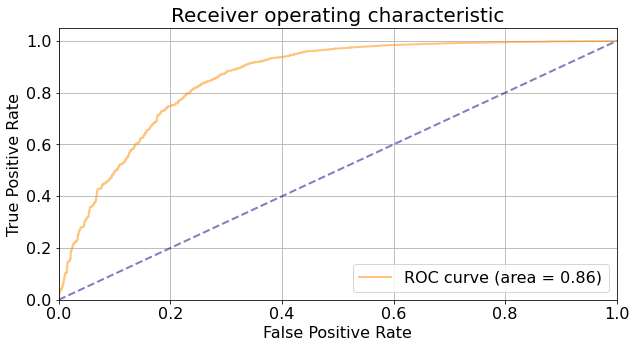

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [28]:
# FPR, FNR и THRESHOLD
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

In [29]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

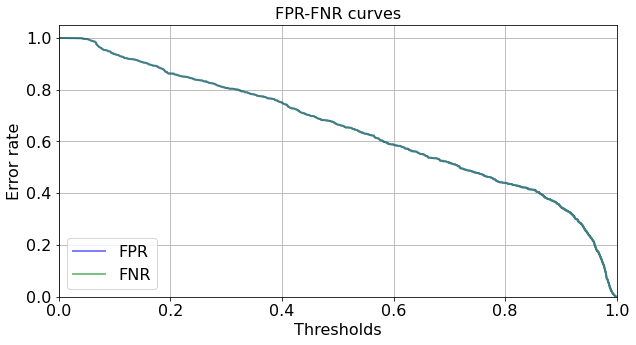

In [30]:
plt.figure(figsize=(10, 5))
lw=2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fpr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Thresholds', fontsize=16)
plt.ylabel('Error rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=16)
plt.legend(loc='lower left', fontsize=16)
plt.show()

In [31]:
# Snapshot
# model = CatBoostClassifier(
#     iterations=150,
#     save_snapshot=True,
#     snapshot_file='shapshot.bkp', # В данный файл будем писать наш прогресс
#     snapshot_interval=1, # Интервал с которым необходимо делать снэпшот
#     random_seed=42
# )

# model.fit(
#     X_train, y_train,
#     eval_set=(X_test, y_test),
#     cat_features=cat_features,
#     verbose=50
# )

In [32]:
# predict_proba
print(model.predict_proba(X_test))

[[0.012  0.988 ]
 [0.011  0.989 ]
 [0.007  0.993 ]
 ...
 [0.079  0.921 ]
 [0.0036 0.9964]
 [0.009  0.991 ]]


In [33]:
# predict
print(model.predict(X_test))

[1 1 1 ... 1 1 1]


In [34]:
# get_feature_importance()
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RESOURCE,19.725472
1,ROLE_DEPTNAME,18.964845
2,MGR_ID,13.535913
3,ROLE_ROLLUP_2,12.422688
4,ROLE_FAMILY_DESC,10.734253
5,ROLE_ROLLUP_1,7.109167
6,ROLE_FAMILY,6.828525
7,ROLE_TITLE,6.319407
8,ROLE_CODE,4.359728


In [35]:
# Feature Evaluation
from catboost.eval.catboost_evaluation import *

In [36]:
learn_params= {
    'iterations': 50, 
    'learning_rate': 0.5,
    'random_seed':0,
    'verbose': False,
    'loss_function': 'Logloss',
    'boosting_type': 'Plain'
}

evaluator = CatboostEvaluation(
    'amazon/train.tsv',
    fold_size=10000,
    fold_count=20,
    column_description='amazon/train.cd',
    partition_random_seed=0
)

result=evaluator.eval_features(learn_config=learn_params,
                              eval_metrics=['Logloss', 'Accuracy'],
                              features_to_eval=[1, 3, 8])

In [37]:
from catboost.eval.evaluation_result import *

In [38]:
logloss_result=result.get_metric_results('Logloss')
logloss_result.get_baseline_comparison(
    ScoreConfig(ScoreType.Rel, overfit_iterations_info=False)
)

,PValue,Score,Quantile 0.005,Quantile 0.995,Decision
Features: 1,0.000089,5.782096,5.408473,6.175224,GOOD
Features: 3,0.025094,0.308623,0.031600,0.620381,UNKNOWN
Features: 8,0.204330,-0.165346,-0.487254,0.167278,UNKNOWN


In [39]:
# save model
best_model = CatBoostClassifier(iterations=100)
best_model = model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    cat_features=cat_features,
    verbose=False
)

best_model.save_model('catboost_model.json')
best_model.save_model('catboost_model.bin')

In [40]:
best_model.load_model('catboost_model.bin')
print(best_model.get_params())
print(best_model.random_seed_)

{'iterations': 200, 'learning_rate': 0.15, 'random_seed': 63, 'custom_loss': ['AUC', 'Accuracy'], 'custom_metric': ['AUC', 'Accuracy'], 'loss_function': 'Logloss', 'verbose': 0}
63
